Name: Priyansh Khunger<br>
Roll Number: 2020101056<br>
Assignment 2: Image Classification

In [ ]:
pip install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 277.3/277.3 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 6.2 MB/s eta 0:00:00


Including the necessary libraries

In [ ]:
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import cv2
import numpy as np
from sklearn.cluster import KMeans
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from scipy.spatial import distance
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import wandb

Loading the MNIST data set from Pytorch

In [ ]:
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=None)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=None)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 54497505.86it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 1647723.57it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 9218373.85it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 3664972.83it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



Now, going over every image in the training data set and extracting features out of every image and then collecting all the features in a list.

In [ ]:
sift = cv2.SIFT_create()

# Initialize lists to store keypoints and descriptors
all_keypoints = []
all_descriptors = []

# Loop over the entire training dataset
for i in range(len(train_dataset)):
    # Get the image and its corresponding label
    image, label = train_dataset[i]

    # Convert the image to numpy array
    image = np.array(image)

    # Detect keypoints and compute descriptors
    keypoints, descriptors = sift.detectAndCompute(image, None)

    # Append keypoints and descriptors to lists
    if descriptors is not None:
      all_keypoints.append(keypoints)
      all_descriptors.append(descriptors)

Converting the lists into numpy arrays now.

In [ ]:
# Convert the lists of keypoints and descriptors to numpy arrays
all_keypoints_array = np.concatenate(all_keypoints)
all_descriptors_array = np.concatenate(all_descriptors)

Making Visual Words from all the features extracted from the SIFT detector(Cluster Centers). This is done by using K-means Clustering to make the cluster centers.

In [ ]:
k = 50
kmeans = KMeans(n_clusters=k, n_init='auto')
kmeans.fit(all_descriptors_array)

# Get cluster centers
cluster_centers = kmeans.cluster_centers_

Now, for every image in the training data set, we will calculate the histogram with the help of cluster centers which will be further fed in a linear classifier.

In [ ]:
# Compute histograms of visual words for each image
def compute_histogram(image, k, kmeans):
    # Detect keypoints and compute descriptors
    image = np.array(image)
    _, descriptors = sift.detectAndCompute(image, None)

    # Compute histogram
    histogram = np.zeros(k)
    if descriptors is not None:
      labels = kmeans.predict(descriptors)
      histogram, _ = np.histogram(labels, bins=range(k+1))
    return histogram

Representing histograms for 1st image and the 25th image.

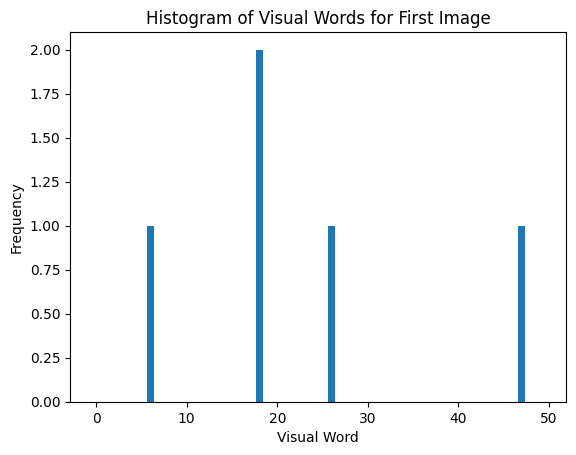

In [ ]:
# Compute histograms for all images in the dataset
histograms = []
for image, label in train_dataset:
    histogram = compute_histogram(image, k, kmeans)
    histograms.append(histogram)

# Display histogram for the first image (optional)
plt.bar(range(k), histograms[0])
plt.xlabel('Visual Word')
plt.ylabel('Frequency')
plt.title('Histogram of Visual Words for First Image')
plt.show()

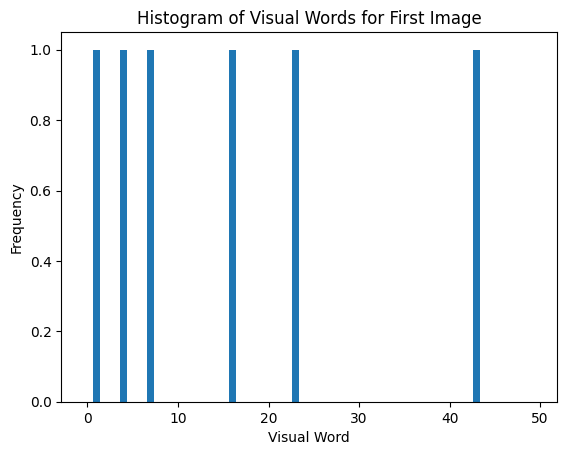

In [ ]:
plt.bar(range(k), histograms[24])
plt.xlabel('Visual Word')
plt.ylabel('Frequency')
plt.title('Histogram of Visual Words for First Image')
plt.show()

Now, putting all the histograms in a linear SVM model.

In [ ]:
X_train = np.array(histograms)
y_train = np.array([target for _, target in train_dataset])

# Initialize and train linear SVM model
svm_model = LinearSVC(max_iter=100000)
svm_model.fit(X_train, y_train)

LinearSVC(max_iter=100000)

In [ ]:
histograms_test = []
for image, label in test_dataset:
  temp = compute_histogram(image, 50, kmeans)
  histograms_test.append(temp)

In [ ]:
X_test = np.array(histograms_test)
y_test = np.array([target for _, target in test_dataset])

Calculating the accuracy using a test data set.

In [ ]:
y_pred = svm_model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.6639


Question: 1.2<br> Now,calculating the accuracy for different values of number of cluster centers i.e. different values of k.<br>Further plotting these accuracies using MatplotLib.

In [ ]:
k_values = [1, 2, 5, 10, 20, 50, 100, 200, 500, 1000, 2000]

accuracies = []

# Iterate over different values of k
for k in k_values:

    # Perform k-means clustering on training data
    kmeans = KMeans(n_clusters=k, n_init='auto')
    kmeans.fit(all_descriptors_array)

    histogram_train = []
    for image, label in train_dataset:
      histogram = compute_histogram(image, k, kmeans)
      histogram_train.append(histogram)

    histogram_test = []
    for image, label in test_dataset:
      histogram = compute_histogram(image, k, kmeans)
      histogram_test.append(histogram)

    # Train a linear SVM classifier
    train_histograms = np.array(histogram_train)
    test_histograms = np.array(histogram_test)

    svm_new_model = LinearSVC(max_iter=k*1000000)
    svm_new_model.fit(train_histograms, y_train)

    # Predict labels on the testing set
    y_pred = svm_new_model.predict(test_histograms)

    # Calculate classification accuracy and store it
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)

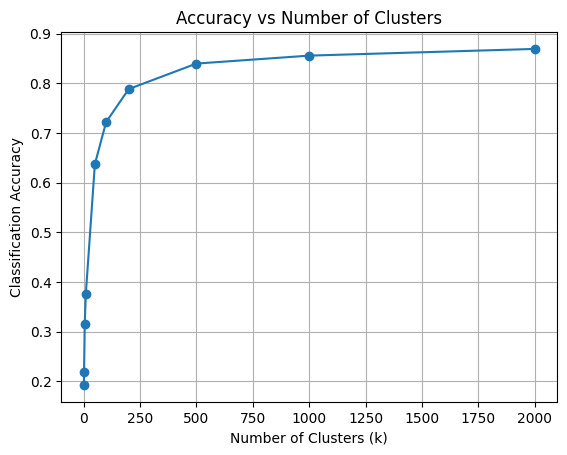

In [ ]:
# Plot the results
plt.plot(k_values, accuracies, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Classification Accuracy')
plt.title('Accuracy vs Number of Clusters')
plt.grid(True)
plt.show()

The reason for increased accuracy can be attributed to the fact that when we have more cluster centers, more information can be learned from the images.

Question 1.3<br>So, we changed the parameter of the SIFT detector and SVM in the question.<br>For SIFT, we changed Number of Octave Layers and edgeThreshold which basically means the value of sigma and some features will be extracted based on the detection of edges.<br>So if we have a less of threshold, then it will detect keep more features which are having edges. But in case of a higher threshold, it will ignore the featurs which are having less edgy part in them.<br>And for SVM, we used the Regularisation parameter. For higher values of Regularisation parameter, it basically wants to make the accuracy better but it can lead to overfitting. While lower values focus on maximising the margin.

In [ ]:
sift_parameters = [
    {'nOctaveLayers': 4, 'edgeThreshold':5.0},
    {'nOctaveLayers': 4, 'edgeThreshold':3.0},
    {'nOctaveLayers': 5, 'edgeThreshold':5.0},
    {'nOctaveLayers': 5, 'edgeThreshold':3.0}
]

# Define different SVM parameters to explore
svm_parameters = [
    {'C': 1.0},
    {'C': 10.0}
]

In [ ]:
new_accuracies = []

y_train = np.array([target for _, target in train_dataset])
y_test = np.array([target for _, target in test_dataset])

# Iterate over different SIFT parameters
for sift_params in sift_parameters:
  # Initialize SIFT detector with current parameters
  sift = cv2.SIFT_create(edgeThreshold=sift_params['edgeThreshold'], nOctaveLayers=sift_params['nOctaveLayers'])

  new_keypoints = []
  new_descriptors = []

  for i in range(len(train_dataset)):
    image, label = train_dataset[i]

    image = np.array(image)

    keypoints, descriptors = sift.detectAndCompute(image, None)

    if descriptors is not None:
      new_keypoints.append(keypoints)
      new_descriptors.append(descriptors)


  # Convert the lists of keypoints and descriptors to numpy arrays
  new_keypoints_array = np.concatenate(new_keypoints)
  new_descriptors_array = np.concatenate(new_descriptors)


  k = 50
  kmeans = KMeans(n_clusters=k, n_init="auto")
  kmeans.fit(new_descriptors_array)

  histogram_train = []
  for image, label in train_dataset:
    histogram = compute_histogram(image, k, kmeans)
    histogram_train.append(histogram)

  histogram_test = []
  for image, label in test_dataset:
    histogram = compute_histogram(image, k, kmeans)
    histogram_test.append(histogram)

  train_histograms = np.array(histogram_train)
  test_histograms = np.array(histogram_test)

  for svm_params in svm_parameters:
    clf = LinearSVC(C=svm_params['C'], max_iter=k*1000000)
    clf.fit(train_histograms, y_train)

    y_pred = clf.predict(test_histograms)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"The accuracy for {sift_params} and {svm_params} is {accuracy}")
    new_accuracies.append(accuracy)

The accuracy for {'nOctaveLayers': 4, 'edgeThreshold': 5.0} and {'C': 1.0} is 0.6189
The accuracy for {'nOctaveLayers': 4, 'edgeThreshold': 5.0} and {'C': 10.0} is 0.6188
The accuracy for {'nOctaveLayers': 4, 'edgeThreshold': 3.0} and {'C': 1.0} is 0.5582
The accuracy for {'nOctaveLayers': 4, 'edgeThreshold': 3.0} and {'C': 10.0} is 0.5582
The accuracy for {'nOctaveLayers': 5, 'edgeThreshold': 5.0} and {'C': 1.0} is 0.636
The accuracy for {'nOctaveLayers': 5, 'edgeThreshold': 5.0} and {'C': 10.0} is 0.6361
The accuracy for {'nOctaveLayers': 5, 'edgeThreshold': 3.0} and {'C': 1.0} is 0.5632
The accuracy for {'nOctaveLayers': 5, 'edgeThreshold': 3.0} and {'C': 10.0} is 0.5632


Here, we can see that

In [ ]:
new_accuracies

[0.6189, 0.6188, 0.5582, 0.5582, 0.636, 0.6361, 0.5632, 0.5632]

*Question* 2.1

Now, here we are going to make the architecture of CNN. We have 2 convolutional layers, relu layers and pooling layers. And then we have a densely connected neural network which will use the information extracted from the convolutional layers and use that for classification purposes.

In [ ]:
# 2. Define the LeNet architecture
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.max_pool2d(x, kernel_size=2, stride=2)
        x = torch.relu(self.conv2(x))
        x = torch.max_pool2d(x, kernel_size=2, stride=2)
        x = x.view(-1, 16 * 4 * 4)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

Here, we have written the code to transform all the arrays into tensors which can be further fed into the network.<br>Taken a batch size of 64 for the same.

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

In [ ]:
wandb.init(project="digit-recognition")

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Training of the CNN network, but for 1st case, we plotted the functions using MatPlotLib. But changed the same for further networks.

In [ ]:
def train(model, train_loader, criterion, optimizer, epochs=5):
    #train_losses = []
    for epoch in range(epochs):
        running_loss = 0.0
        #global_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            #global_loss += loss.item()
            if i % 100 == 99:
                print(f'Epoch: {epoch + 1}, Batch: {i + 1}, Loss: {running_loss / 100}')
                running_loss = 0.0
        #epoch_loss = global_loss / len(train_loader)
        #train_losses.append(epoch_loss)
        #wandb.log({"Training Loss": epoch_loss, "epoch": epoch + 1})


    #plt.plot(train_losses)
    #plt.xlabel('Epoch')
    #plt.ylabel('Training Loss')
    #plt.title('Training Loss over Epochs')
    #plt.show()
    #wandb.watch(model)

This function is used to evaluate the model i.e. find its accuracy.

In [ ]:
def evaluate(model, test_loader):
    #eval_losses = []
    #accuracies = []
    eval_loss = 0.0
    total = 0
    correct = 0
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            outputs = model(images)
            loss = criterion(outputs, labels)
            #eval_losses.append(loss.item())
            eval_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            # accuracy = correct / total
            # accuracies.append(accuracy)
    accuracy = correct / total
    print(f'Accuracy on test set: {accuracy}')
    #wandb.log({"Evaluation Loss": eval_loss / len(test_loader), "Accuracy": accuracy})
    #wandb.watch(model)

    # avg_eval_loss = sum(eval_losses) / len(eval_losses)
    # avg_accuracy = sum(accuracies) / len(accuracies)
    # print(f'Average evaluation loss: {avg_eval_loss}, Average accuracy: {avg_accuracy}')
    #plt.plot(eval_losses)
    #plt.xlabel('Batch')
    #plt.ylabel('Evaluation Loss')
    #plt.title('Evaluation Loss per Batch')
    #plt.show()
    return accuracy

Now, making the model with the help of architectture defined above and using a learning rate of 0.001 and Adam Optimiser to train the network.

In [ ]:
model = LeNet()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Epoch: 1, Batch: 100, Loss: 1.1762982633709909
Epoch: 1, Batch: 200, Loss: 0.3218878117948771
Epoch: 1, Batch: 300, Loss: 0.22589463278651237
Epoch: 1, Batch: 400, Loss: 0.16472116507589818
Epoch: 1, Batch: 500, Loss: 0.15884777676314116
Epoch: 1, Batch: 600, Loss: 0.11834718527272343
Epoch: 1, Batch: 700, Loss: 0.11818300005048514
Epoch: 1, Batch: 800, Loss: 0.10854398760944604
Epoch: 1, Batch: 900, Loss: 0.09087754886597395
Epoch: 2, Batch: 100, Loss: 0.08332129986956716
Epoch: 2, Batch: 200, Loss: 0.079846973689273
Epoch: 2, Batch: 300, Loss: 0.08869397313334047
Epoch: 2, Batch: 400, Loss: 0.07179498922079802
Epoch: 2, Batch: 500, Loss: 0.06657754669431597
Epoch: 2, Batch: 600, Loss: 0.07098101516254246
Epoch: 2, Batch: 700, Loss: 0.0728835195209831
Epoch: 2, Batch: 800, Loss: 0.06157697557704523
Epoch: 2, Batch: 900, Loss: 0.06324115012539551
Epoch: 3, Batch: 100, Loss: 0.053306819442659616
Epoch: 3, Batch: 200, Loss: 0.05656939516309649
Epoch: 3, Batch: 300, Loss: 0.04891546252649

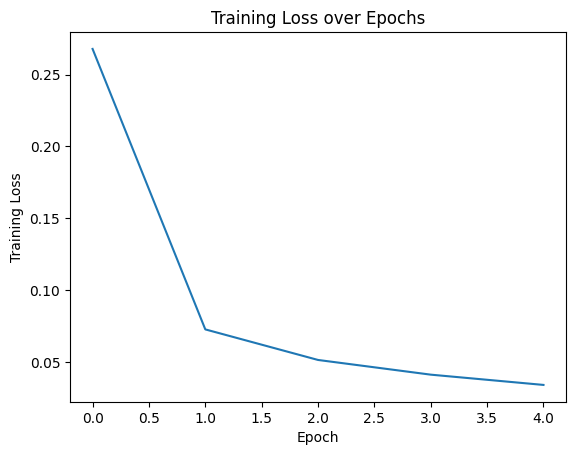

In [ ]:
train(model, train_loader, criterion, optimizer)

Accuracy on test set: 0.9887


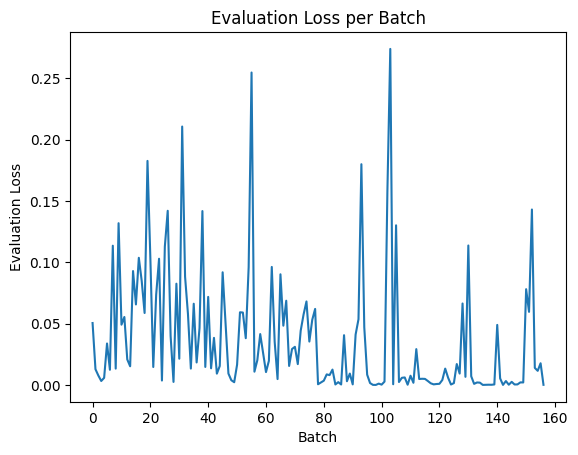

In [ ]:
new_accuracy = evaluate(model, test_loader)

Now, we are making list of batch sizes and learning rates and optimisers we will be using for training the network and see the changes in the accuracy.

In [ ]:
accuracy_array = []
print(accuracy_array)

[]


In [ ]:
batch_size = [32, 64, 128]

learning_rate = [0.001, 0.0001, 0.01]

optimiser = ["Adam", "RMSprop", "SGD"]

In [ ]:
for batch in batch_size:
  train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch, shuffle=True)
  test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch, shuffle=False)

  for alpha in learning_rate:
    for gd in optimiser:
      print(f"We are training for batch size {batch} and learning rate {alpha} and optimiser {gd}")

      model = LeNet()
      criterion = nn.CrossEntropyLoss()
      if gd == "Adam":
        optimizer = optim.Adam(model.parameters(), lr=alpha)
        train(model, train_loader, criterion, optimizer)

      if gd == "RMSprop":
        optimizer = optim.RMSprop(model.parameters(), lr=alpha)
        train(model, train_loader, criterion, optimizer)

      if gd == "SGD":
        optimizer = optim.SGD(model.parameters(), lr=alpha)
        train(model, train_loader, criterion, optimizer)

      new_accuracy = evaluate(model, test_loader)
      accuracy_array.append(new_accuracy)

We are training for batch size 32 and learning rate 0.001 and optimiser Adam
Epoch: 1, Batch: 100, Loss: 1.2880865363776683
Epoch: 1, Batch: 200, Loss: 0.3435318069905043
Epoch: 1, Batch: 300, Loss: 0.23315660711377859
Epoch: 1, Batch: 400, Loss: 0.2012010142020881
Epoch: 1, Batch: 500, Loss: 0.15702960869297386
Epoch: 1, Batch: 600, Loss: 0.13954283881932497
Epoch: 1, Batch: 700, Loss: 0.1490240457188338
Epoch: 1, Batch: 800, Loss: 0.1290337746683508
Epoch: 1, Batch: 900, Loss: 0.1258352660574019
Epoch: 1, Batch: 1000, Loss: 0.11082832539919764
Epoch: 1, Batch: 1100, Loss: 0.10525154690258205
Epoch: 1, Batch: 1200, Loss: 0.1147402334259823
Epoch: 1, Batch: 1300, Loss: 0.07698760913219303
Epoch: 1, Batch: 1400, Loss: 0.09011481520254165
Epoch: 1, Batch: 1500, Loss: 0.1023820479423739
Epoch: 1, Batch: 1600, Loss: 0.09370369885582477
Epoch: 1, Batch: 1700, Loss: 0.07746812546625734
Epoch: 1, Batch: 1800, Loss: 0.07822401382029057
Epoch: 2, Batch: 100, Loss: 0.06548838965478353
Epoch: 2, 

In [ ]:
accuracy_array

[0.9892,
 0.9883,
 0.8733,
 0.9802,
 0.9782,
 0.1327,
 0.9725,
 0.9474,
 0.9795,
 0.9888,
 0.9865,
 0.3258,
 0.9753,
 0.9688,
 0.0842,
 0.9814,
 0.9747,
 0.9708,
 0.9892,
 0.9904,
 0.3739,
 0.9621,
 0.958,
 0.0974,
 0.9814,
 0.9766,
 0.9534]

By looking at the accuracies, we can say that the first of all, SGD optimiser is very bad. And further, we can say that increasing learning rate also has a bad impact on the model's training and testing. Batch size did not have much impact on the model.

Now, here we are doubling the convolutional layers of the model.

In [ ]:
class LeNetNew(nn.Module):
    def __init__(self):
        super(LeNetNew, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=3)
        self.conv2 = nn.Conv2d(6, 12, kernel_size=3)  # Doubled the number of filters
        self.conv3 = nn.Conv2d(12, 16, kernel_size=3)  # Additional convolutional layer
        self.fc1 = nn.Linear(16 * 7 * 7, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.max_pool2d(x, kernel_size=2, stride=2)   # yaha tak 12 hai size
        x = torch.relu(self.conv2(x))
        x = torch.max_pool2d(x, kernel_size=2, stride=1)
        x = torch.relu(self.conv3(x))  # Additional convolutional layer
        x = torch.max_pool2d(x, kernel_size=2, stride=1)
        x = x.view(-1, 16 * 7 * 7)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

In [ ]:
model = LeNetNew()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
train(model, train_loader, criterion, optimizer)

Epoch: 1, Batch: 100, Loss: 1.1462961107492446
Epoch: 1, Batch: 200, Loss: 0.342403824403882
Epoch: 1, Batch: 300, Loss: 0.23816611051559447
Epoch: 1, Batch: 400, Loss: 0.19316044664010407
Epoch: 1, Batch: 500, Loss: 0.15079670991748573
Epoch: 1, Batch: 600, Loss: 0.15939251204952598
Epoch: 1, Batch: 700, Loss: 0.12920155515894294
Epoch: 1, Batch: 800, Loss: 0.10840411154553294
Epoch: 1, Batch: 900, Loss: 0.10509810611605644
Epoch: 2, Batch: 100, Loss: 0.10199336886405945
Epoch: 2, Batch: 200, Loss: 0.08951010951772333
Epoch: 2, Batch: 300, Loss: 0.08853879064321518
Epoch: 2, Batch: 400, Loss: 0.07551752957515419
Epoch: 2, Batch: 500, Loss: 0.07722017226740718
Epoch: 2, Batch: 600, Loss: 0.07506508838851005
Epoch: 2, Batch: 700, Loss: 0.07370258399751037
Epoch: 2, Batch: 800, Loss: 0.0804870923422277
Epoch: 2, Batch: 900, Loss: 0.06921251874766313
Epoch: 3, Batch: 100, Loss: 0.061856495207175614
Epoch: 3, Batch: 200, Loss: 0.061648492091335355
Epoch: 3, Batch: 300, Loss: 0.067668986502

In [ ]:
new_accuracy = evaluate(model, test_loader)

Accuracy on test set: 0.9891


Performance of the model did not change much attributing to the fact that the earlier model was already performing very well and at the same time, this will just increase the computation cost of the network.

Now, we are training the model using different number of training examples.

In [ ]:
training_examples = [600, 1800, 6000, 18000, 60000]

accuracies_final = []

for i in training_examples:
  transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
  ])

  full_train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
  test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

  subset_indices = range(i)
  train_subset = torch.utils.data.Subset(full_train_dataset, subset_indices)

  train_loader = torch.utils.data.DataLoader(train_subset, batch_size=64, shuffle=True)
  test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

  model = LeNet()
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(model.parameters(), lr=0.001)

  train(model, train_loader, criterion, optimizer)
  new_accuracy = evaluate(model, test_loader)
  accuracies_final.append(new_accuracy)

Accuracy on test set: 0.7657
Accuracy on test set: 0.8928
Accuracy on test set: 0.9618
Epoch: 1, Batch: 100, Loss: 1.2360245981812477
Epoch: 1, Batch: 200, Loss: 0.3340280335396528
Epoch: 2, Batch: 100, Loss: 0.1788882625848055
Epoch: 2, Batch: 200, Loss: 0.15048644799739122
Epoch: 3, Batch: 100, Loss: 0.10802443316206337
Epoch: 3, Batch: 200, Loss: 0.1029364775121212
Epoch: 4, Batch: 100, Loss: 0.08534483942668886
Epoch: 4, Batch: 200, Loss: 0.08105941003654152
Epoch: 5, Batch: 100, Loss: 0.06556883805897087
Epoch: 5, Batch: 200, Loss: 0.06466560585424304
Accuracy on test set: 0.9778
Epoch: 1, Batch: 100, Loss: 0.9825057207047939
Epoch: 1, Batch: 200, Loss: 0.27575979836285114
Epoch: 1, Batch: 300, Loss: 0.20904371090233326
Epoch: 1, Batch: 400, Loss: 0.17206484131515026
Epoch: 1, Batch: 500, Loss: 0.1430321492627263
Epoch: 1, Batch: 600, Loss: 0.12676506008952856
Epoch: 1, Batch: 700, Loss: 0.11147097826004028
Epoch: 1, Batch: 800, Loss: 0.09732945872470737
Epoch: 1, Batch: 900, Loss

So, more the number of examples, more the model learns from it.

In [ ]:
accuracies_final

[0.7657, 0.8928, 0.9618, 0.9778, 0.9877]

Now, we are making a VIT tranformer which will take in the same data set. The nnumer of encoding layers will 2.<br>Here, we convert the image firsly into image patches then converted them into vector embeddings basically getting the features and then further adding the positional encodings to the embeddings. Further these are sent into the encoding layer and rich embeddings are generated. Out of these rich embeddings as output, we make a cls token which represents the generalised representation of the output sequence.

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

# Define the hyperparameters
batch_size = 64
num_classes = 10
patch_size = 7
num_patches = (28 // patch_size) ** 2
embedding_dim = 64
num_heads = 4
num_layers = 2
dropout = 0.1

# Define the ViT-style Transformer Encoder model
class TransformerEncoder(nn.Module):
    def __init__(self):
        super(TransformerEncoder, self).__init__()
        self.patch_embedding = nn.Conv2d(1, embedding_dim, kernel_size=patch_size, stride=patch_size)
        self.position_embedding = nn.Parameter(torch.randn(1, num_patches + 1, embedding_dim))
        self.cls_token = nn.Parameter(torch.randn(1, 1, embedding_dim))
        self.dropout = nn.Dropout(dropout)

        encoder_layer = nn.TransformerEncoderLayer(d_model=embedding_dim, nhead=num_heads, dim_feedforward=embedding_dim * 4, dropout=dropout, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.fc = nn.Linear(embedding_dim, num_classes)

    def forward(self, x):
        # Patch embedding
        x = self.patch_embedding(x)
        x = x.flatten(2).transpose(1, 2)

        # Add class token and position embedding
        cls_token = self.cls_token.expand(x.shape[0], -1, -1)
        x = torch.cat((cls_token, x), dim=1)
        x = x + self.position_embedding

        # Transformer encoder
        x = self.dropout(x)
        x = self.transformer_encoder(x)

        # Classification
        cls_token = x[:, 0]
        x = self.fc(cls_token)

        return x

In [ ]:
# Define the data transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Load the MNIST dataset
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Create data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
# Create the model instance
model = TransformerEncoder()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
num_epochs = 10
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, (images, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        if i % 100 == 99:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{len(train_loader)}], Loss: {running_loss / 100:.3f}')
            running_loss = 0.0

Epoch [1/10], Step [100/938], Loss: 1.438
Epoch [1/10], Step [200/938], Loss: 0.665
Epoch [1/10], Step [300/938], Loss: 0.493
Epoch [1/10], Step [400/938], Loss: 0.421
Epoch [1/10], Step [500/938], Loss: 0.379
Epoch [1/10], Step [600/938], Loss: 0.361
Epoch [1/10], Step [700/938], Loss: 0.341
Epoch [1/10], Step [800/938], Loss: 0.328
Epoch [1/10], Step [900/938], Loss: 0.292
Epoch [2/10], Step [100/938], Loss: 0.277
Epoch [2/10], Step [200/938], Loss: 0.266
Epoch [2/10], Step [300/938], Loss: 0.272
Epoch [2/10], Step [400/938], Loss: 0.269
Epoch [2/10], Step [500/938], Loss: 0.225
Epoch [2/10], Step [600/938], Loss: 0.222
Epoch [2/10], Step [700/938], Loss: 0.229
Epoch [2/10], Step [800/938], Loss: 0.218
Epoch [2/10], Step [900/938], Loss: 0.230
Epoch [3/10], Step [100/938], Loss: 0.203
Epoch [3/10], Step [200/938], Loss: 0.200
Epoch [3/10], Step [300/938], Loss: 0.209
Epoch [3/10], Step [400/938], Loss: 0.207
Epoch [3/10], Step [500/938], Loss: 0.196
Epoch [3/10], Step [600/938], Loss

In [ ]:
# Test the model
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy on the test set: {100 * correct / total:.2f}%')


Accuracy on the test set: 96.41%


The accuracy is similar to that of a CNN model, but the time taken to train this model is more. So transformer is basically better than CNN as it applies the concept of multi-head attention but it is computationally more expensive to train.